In [58]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from pytt.utils import read_pickle
from utils import precision_recall_f1
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import numpy as np
from torch import tensor # TODO: take out when bug fixed

In [67]:
import copy
def get_curve_args(df):
    sentence_rankings, sentence_labels = [], []
    for i,row in df.iterrows():
        num_report_clusters = row.num_report_clusters
        sentence_rankings_temp = list(range(num_report_clusters))
        reference_sentence_rankings = set(eval(row.reference_sentence_rankings))
        sentence_labels_temp = [(i in reference_sentence_rankings) for i in sentence_rankings_temp]
        sentence_rankings += (np.array(sentence_rankings_temp)/num_report_clusters).tolist()
        sentence_labels += sentence_labels_temp
    
    return np.array(sentence_labels, dtype=np.float), -np.array(sentence_rankings, dtype=np.float)

def get_rankings(df):
#     return sum([(np.array(eval(row.reference_sentence_rankings))/eval(row.num_report_sentences).item()).tolist() for i,row in df.iterrows()], [])
    return sum([(np.array(eval(row.reference_sentence_rankings))/row.num_report_clusters).tolist() for i,row in df.iterrows()], [])

def plot_rankings(rankings):
    plt.hist(rankings, bins=20)
    plt.axis([0, 1, 0, 300])

def make_plots(dfs, plot_directory):
    rankings = {model:get_rankings(df) for model,df in dfs.items()}
    roc_curves = {model:roc_curve(*get_curve_args(df)) for model,df in dfs.items()}
    roc_auc = {model:roc_auc_score(*get_curve_args(df)) for model,df in dfs.items()}
    precision_recall_curves = {model:precision_recall_curve(*get_curve_args(df)) for model,df in dfs.items()}
    average_precision = {model:average_precision_score(*get_curve_args(df)) for model,df in dfs.items()}
    for model,mrankings in rankings.items():
        print(model)
        plot_rankings(mrankings)
        plt.savefig(os.path.join(plot_directory, 'rankings_distribution_%s.png' % model))
        plt.show()
    print("roc_auc:")
    print(roc_auc)
    print("average_precision:")
    print(average_precision)
    for model,(fpr, tpr, thresholds) in roc_curves.items():
        line, = plt.plot(fpr, tpr)
        line.set_label(model)
        plt.legend()
    #     plt.show()
    # plt.plot([0,1],[0,1])
    plt.savefig(os.path.join(plot_directory, 'roc_curve.png'))
    plt.show()
    for model,(p, r, thresholds) in precision_recall_curves.items():
        line, = plt.plot(p, r)
        line.set_label(model)
        plt.legend()
    #     plt.show()
    plt.axis([0,.15,0,1])
    plt.savefig(os.path.join(plot_directory, 'precision_recall_curve.png'))
    plt.show()

def limit_summary_sentences(df, summary_sentences):
    newdf = []
    for i,row in df.iterrows():
        if (row.timepoint_id, row.code_name) not in summary_sentences.keys(): continue
        sentences = summary_sentences[(row.timepoint_id, row.code_name)]
        newrow = copy.deepcopy(row)
        orsis, orsrs, orsa = eval(row.reference_sentence_indices), eval(row.reference_sentence_rankings), eval(row.reference_sentence_attention)
        newrow.reference_sentence_indices = str([orsis[i] for i in sentences])
        newrow.reference_sentence_rankings = str([orsrs[i] for i in sentences])
        newrow.reference_sentence_attention = str([orsa[i] for i in sentences])
        newdf.append(newrow)
    return pd.DataFrame(newdf)

In [68]:
models = ['tfidf', 'cosine', 'codes', 'description', 'linearization']
base_path = "/Users/jeredmcinerney/Desktop/summary_stats/%s.csv"
# models = ['500', '1000', ]
# base_path = "/Users/jeredmcinerney/Desktop/stats_progression/summary_stats%s.csv"
dfs = {model:pd.read_csv(base_path % model) for model in models}
tfidf_zero_summary_sentences = {
    (r.timepoint_id, r.code_name):
        [i for i,rsa in enumerate(eval(r.reference_sentence_attention)) if rsa == 0]
    for _,r in dfs['tfidf'].iterrows()}
tfidf_nonzero_summary_sentences = {
    (r.timepoint_id, r.code_name):
        [i for i,rsa in enumerate(eval(r.reference_sentence_attention)) if rsa != 0]
    for _,r in dfs['tfidf'].iterrows()}
dfs_tfidf_zero = {m:limit_summary_sentences(df, tfidf_zero_summary_sentences) for m,df in dfs.items()}
dfs_tfidf_nonzero = {m:limit_summary_sentences(df, tfidf_nonzero_summary_sentences) for m,df in dfs.items()}

tfidf


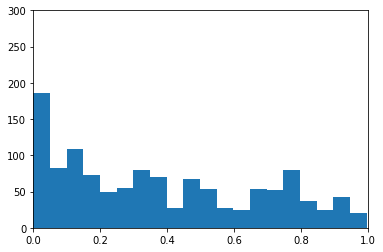

cosine


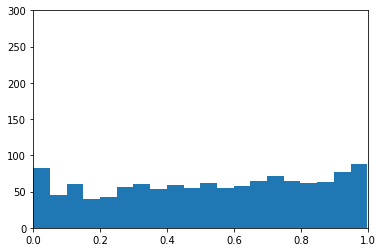

codes


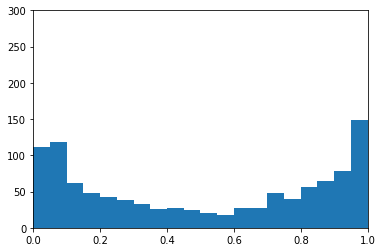

description


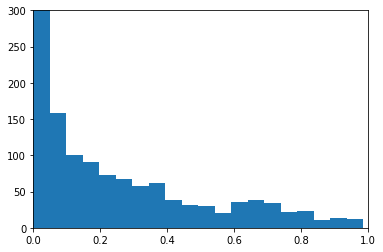

linearization


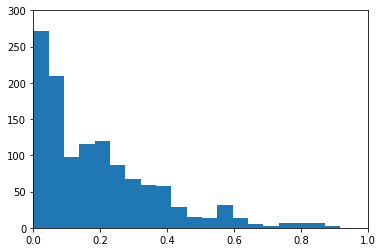

roc_auc:
{'tfidf': 0.6135147333761836, 'cosine': 0.47156720884667297, 'codes': 0.4990938038458335, 'description': 0.7443371686307527, 'linearization': 0.8104277730564842}
average_precision:
{'tfidf': 0.04020427409844793, 'cosine': 0.019163324602824102, 'codes': 0.028284531825811438, 'description': 0.06000540196393457, 'linearization': 0.07002625610541921}


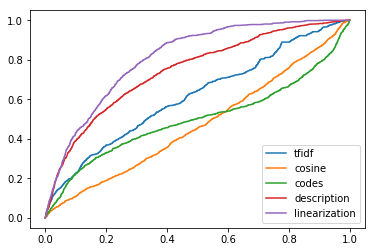

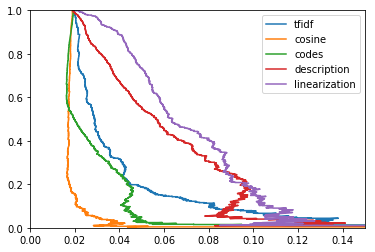

In [69]:
make_plots(dfs, '/Users/jeredmcinerney/Desktop/plots')

tfidf


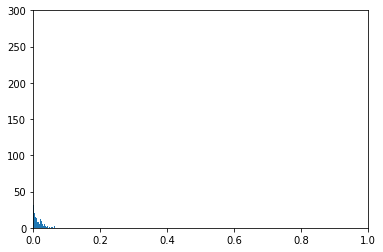

cosine


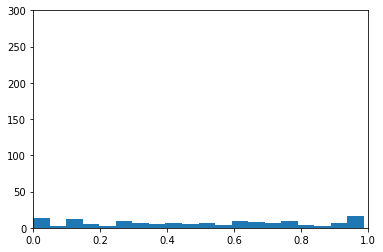

codes


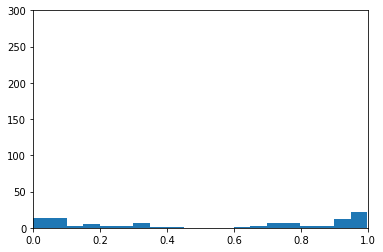

description


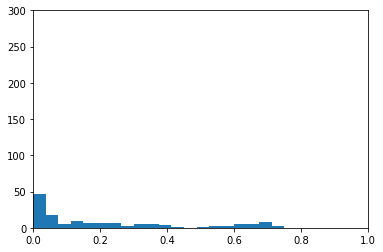

linearization


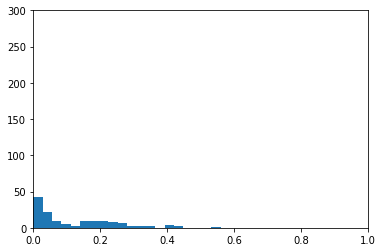

roc_auc:
{'tfidf': 0.9859504856466254, 'cosine': 0.5072758582147978, 'codes': 0.4722058856699383, 'description': 0.7990221465980452, 'linearization': 0.8775577886263618}
average_precision:
{'tfidf': 0.09421733730660434, 'cosine': 0.0032485598245376827, 'codes': 0.003822062327897941, 'description': 0.012008179432689918, 'linearization': 0.01801120249924375}


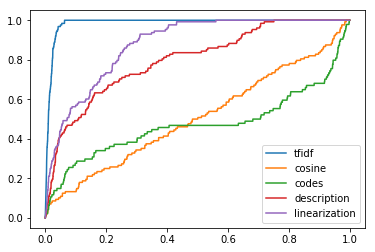

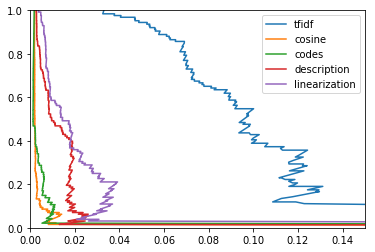

In [70]:
make_plots(dfs_tfidf_nonzero, '/Users/jeredmcinerney/Desktop/plots')

tfidf


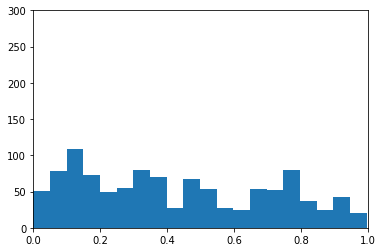

cosine


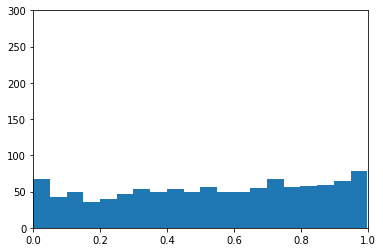

codes


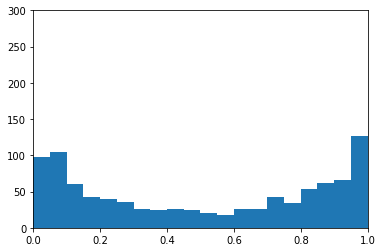

description


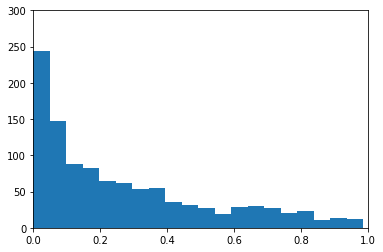

linearization


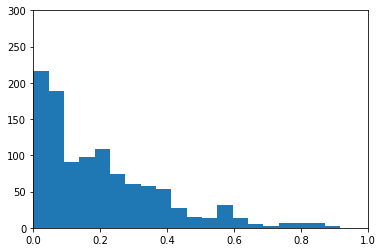

roc_auc:
{'tfidf': 0.5660241041433284, 'cosine': 0.4671410200775471, 'codes': 0.5019413368658363, 'description': 0.7363259820731853, 'linearization': 0.8005485236634676}
average_precision:
{'tfidf': 0.020729192516896155, 'cosine': 0.01639576697777752, 'codes': 0.02490614476793319, 'description': 0.04959489746782939, 'linearization': 0.05606374093176552}


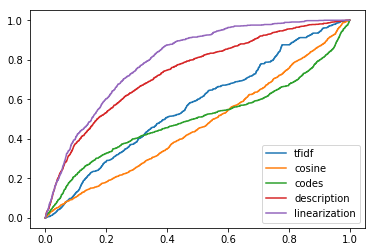

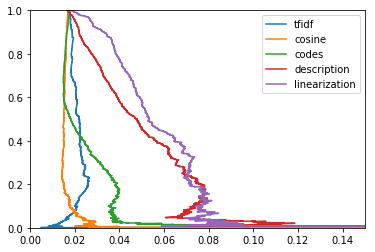

In [72]:
make_plots(dfs_tfidf_zero, '/Users/jeredmcinerney/Desktop/plots')